In [33]:
import ast

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../data/responses_full.csv")

In [3]:
df['history'] = df['history'].apply(ast.literal_eval)
df['choices'] = df['choices'].apply(ast.literal_eval)

In [4]:
df = df.drop_duplicates(subset=["user_id"])

In [5]:
df["selection_count"] = df["history"].apply(len)

In [6]:
def process_choices(choices):
    chosen_headlines = []
    for _, v in choices.items():
        selected = v["selected"]
        options = v["options"]
        for hed, source in options.items():
            if hed == selected:
                chosen_headlines.append(source)
    
    return chosen_headlines

In [7]:
df["preference"] = df["choices"].apply(process_choices)

In [8]:
df["proportion_generated"] = df.preference.apply(lambda x: sum([1 for y in x if y == "Generated"]) / len(x))

In [10]:
df[["selection_count", "proportion_generated"]].corr()

,selection_count,proportion_generated
selection_count,1.000000,-0.094346
proportion_generated,-0.094346,1.000000


In [55]:
def analyze_binary_choices(ai_selection_count, n_responses, alpha=0.05):
    """
    Analyze binary choice data.
    
    Parameters:
    -----------
    ai_selection_count : list or array
        Number of times the AI-generated headline was chosen for each question
    n_responses : int
        Total number of responses per question
    alpha : float, optional
        Significance level for statistical tests (default: 0.05)
        
    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    # Convert inputs to numpy arrays
    option_a_counts = np.array(ai_selection_count)
    n_questions = len(option_a_counts)
    total_trials = n_responses * n_questions
    
    # Pooled binomial test
    total_option_a = np.sum(option_a_counts)
    pooled_result = stats.binomtest(total_option_a, total_trials, p=0.5)
    
    # Calculate confidence interval for pooled proportion
    ci = pooled_result.proportion_ci()
    ci_lower, ci_upper = ci.low, ci.high

    # Chi-square test for homogeneity
    pooled_prop = total_option_a / total_trials
    expected = pooled_prop * n_responses
    chi2_stat = np.sum((option_a_counts - expected)**2 / expected + 
                      (n_responses - option_a_counts - (n_responses - expected))**2 / (n_responses - expected))
    chi2_p = stats.chi2.sf(chi2_stat, df=n_questions-1)
    
    # Individual binomial tests for each question
    individual_tests = []
    for i, count in enumerate(option_a_counts):
        result = stats.binomtest(count, n_responses, p=0.5)
        ci = result.proportion_ci()
        ci_lower, ci_upper = ci.low, ci.high
        individual_tests.append({
            'question': i + 1,
            'total_generated': count,
            'proportion': count / n_responses,
            'statistic': result.statistic,
            'p_value_corrected': result.pvalue * n_questions,
            'significant_corrected': result.pvalue * n_questions < alpha,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        })
    
    # Compile results
    results = {
        'pooled_analysis': {
            'total_generated': total_option_a,
            'total_trials': total_trials,
            'pooled_proportion': pooled_prop,
            'statistic': pooled_result.statistic,
            'p_value': pooled_result.pvalue,
            'significant': pooled_result.pvalue < alpha,
            'confidence_interval': (ci_lower, ci_upper)
        },
        'heterogeneity_test': {
            'chi2_statistic': chi2_stat,
            'p_value': chi2_p,
            'df': n_questions - 1,
            'significant': chi2_p < alpha
        },
        'individual_tests': individual_tests
    }
    
    return results

def print_analysis(results):
    """
    Print formatted analysis results.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_binary_choices
    """
    print("\nPOOLED ANALYSIS")
    print("===============")
    p = results['pooled_analysis']
    print(f"Total Generated selections: {p['total_generated']} out of {p['total_trials']}")
    print(f"Pooled proportion: {p['pooled_proportion']:.1%}")
    print(f"P-value: {p['p_value']}")
    print(f"Statistically significant: {p['significant']}")
    print(f"95% CI: ({p['confidence_interval'][0]:.1%} to {p['confidence_interval'][1]:.1%})")
    
    print("\nHETEROGENEITY TEST")
    print("==================")
    h = results['heterogeneity_test']
    print(f"Chi-square statistic: {h['chi2_statistic']:.3f} (df={h['df']})")
    print(f"P-value: {h['p_value']:.6f}")
    print(f"Questions significantly different: {h['significant']}")
    
    print("\nINDIVIDUAL QUESTIONS")
    print("===================")
    for test in results['individual_tests']:
        print(f"\nQuestion {test['question']}:")
        print(f"Generated selections: {test['total_generated']}")
        print(f"Proportion: {test['proportion']:.1%}")
        print(f"P-value (corrected): {test['p_value_corrected']:.6f}")
        print(f"Significant: {test['significant_corrected']}")

In [56]:
df["count_generated"] = df.preference.apply(lambda x: sum([1 for y in x if y == "Generated"]))

In [57]:
prefs = df.preference

question_gen_counts = []
for i in range(len(prefs[0])):
    question_gen_counts.append(sum([1 for x in prefs if x[i] == "Generated"]))

In [58]:
res = analyze_binary_choices(question_gen_counts, len(prefs))

In [59]:
print_analysis(res)


POOLED ANALYSIS
Total Generated selections: 311 out of 500
Pooled proportion: 62.2%
P-value: 5.407956956026173e-08
Statistically significant: True
95% CI: (55.8% to 75.2%)

HETEROGENEITY TEST
Chi-square statistic: 8.455 (df=4)
P-value: 0.076251
Questions significantly different: False

INDIVIDUAL QUESTIONS

Question 1:
Generated selections: 51
Proportion: 51.0%
P-value (corrected): 4.602054
Significant: False

Question 2:
Generated selections: 60
Proportion: 60.0%
P-value (corrected): 0.284440
Significant: False

Question 3:
Generated selections: 69
Proportion: 69.0%
P-value (corrected): 0.000916
Significant: True

Question 4:
Generated selections: 65
Proportion: 65.0%
P-value (corrected): 0.017588
Significant: True

Question 5:
Generated selections: 66
Proportion: 66.0%
P-value (corrected): 0.008950
Significant: True


In [42]:
res["pooled_analysis"]

{'total_generated': np.int64(311),
 'total_trials': 500,
 'pooled_proportion': np.float64(0.622),
 'statistic': 0.622,
 'p_value': np.float64(5.407956956026173e-08),
 'significant': np.True_,
 'confidence_interval': (0.5584667322490411, 0.7517764984555914)}

In [48]:
ci_lower

0.5584667322490411

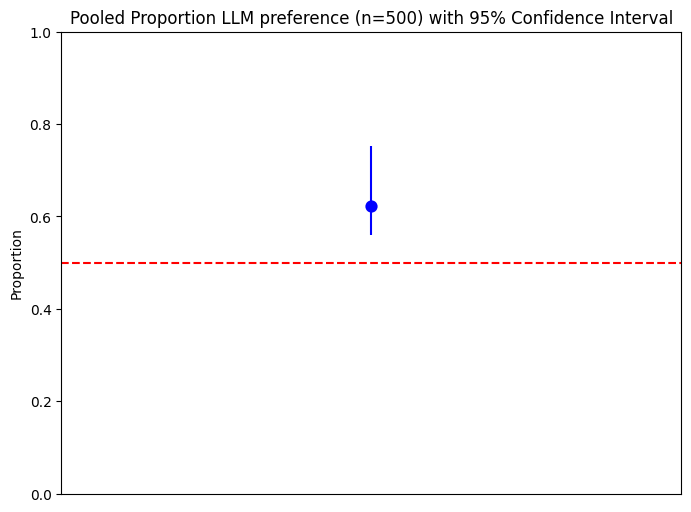

In [49]:
# Extract data from the pooled analysis
pooled_proportion = res['pooled_analysis']['statistic']
ci_lower, ci_upper = res['pooled_analysis']['confidence_interval']

# Create a seaborn plot
plt.figure(figsize=(8, 6))
sns.pointplot(x=[0], y=[pooled_proportion], capsize=0.2, color='blue')
plt.errorbar(x=[0], y=[pooled_proportion], yerr=[[pooled_proportion - ci_lower], [ci_upper - pooled_proportion]], fmt='o', color='blue')

# Add a horizontal line at 0.5
plt.axhline(y=0.5, color='red', linestyle='--')

# Customize the plot
plt.title('Pooled Proportion LLM preference (n=500) with 95% Confidence Interval')
plt.ylabel('Proportion')
plt.xticks([])  # Remove x-axis ticks
plt.ylim(0, 1)  # Set y-axis limits

# Show the plot
plt.show()

In [45]:
res["individual_tests"]

[{'question': 1,
  'total_generated': np.int64(51),
  'proportion': np.float64(0.51),
  'statistic': 0.51,
  'p_value_corrected': np.float64(4.602053813064105),
  'significant_corrected': np.False_,
  'ci_lower': 0.4080363291551743,
  'ci_upper': 0.6113558348383622},
 {'question': 2,
  'total_generated': np.int64(60),
  'proportion': np.float64(0.6),
  'statistic': 0.6,
  'p_value_corrected': np.float64(0.2844396682049039),
  'significant_corrected': np.False_,
  'ci_lower': 0.49720915042233343,
  'ci_upper': 0.696705231297155},
 {'question': 3,
  'total_generated': np.int64(69),
  'proportion': np.float64(0.69),
  'statistic': 0.69,
  'p_value_corrected': np.float64(0.0009157161244117682),
  'significant_corrected': np.True_,
  'ci_lower': 0.5896854458397687,
  'ci_upper': 0.7787112078693281},
 {'question': 4,
  'total_generated': np.int64(65),
  'proportion': np.float64(0.65),
  'statistic': 0.65,
  'p_value_corrected': np.float64(0.017588208614850793),
  'significant_corrected': np.

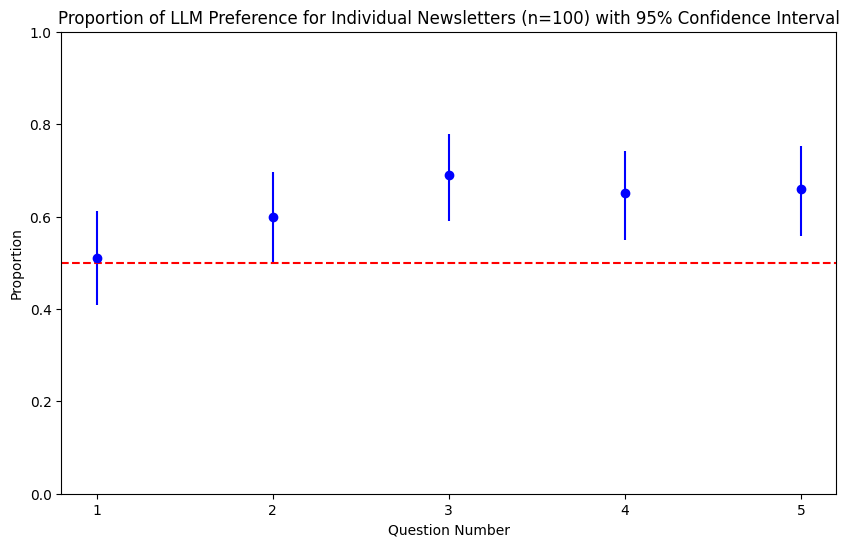

In [54]:
# Extract data for individual questions
individual_tests = res['individual_tests']
question_numbers = [test['question'] for test in individual_tests]
proportions = [test['proportion'] for test in individual_tests]
ci_lowers = [test['ci_lower'] for test in individual_tests]
ci_uppers = [test['ci_upper'] for test in individual_tests]

# Create a seaborn plot for individual questions
plt.figure(figsize=(10, 6))
yerr_lower = [p - l for p, l in zip(proportions, ci_lowers)]
yerr_upper = [u - p for p, u in zip(proportions, ci_uppers)]
plt.errorbar(x=question_numbers, y=proportions, yerr=[yerr_lower, yerr_upper], fmt='o', color='blue')

# Add a horizontal line at 0.5
plt.axhline(y=0.5, color='red', linestyle='--')

# Customize the plot
plt.title('Proportion of LLM Preference for Individual Newsletters (n=100) with 95% Confidence Interval')
plt.xlabel('Question Number')
plt.ylabel('Proportion')
plt.ylim(0, 1)  # Set y-axis limits
plt.xticks(ticks=question_numbers)  # Set x-axis to discrete values

# Show the plot
plt.show()